# 1. `ROOT` basics tutorial

Let's start by importing root and some other libraries needed for the following:

In [1]:
import sys
import os
import ROOT
import numpy as np # library of mathematical functions
import pandas as pd # library for data storage
import matplotlib.pyplot as plt # library for basic plotting
import seaborn as sb # library for statistical plotting

Welcome to JupyROOT 6.20/06


We use ROOT to read the file containing the events and to check what is inside the it:
* `TFile` is the ROOT library for the handling of files
* `GetListOfKeys()` returns the list of names of the object contained in the file
* `Get()` is the general function to get an object. It takes the name of the object as an input
* `GetEntries()` takes no input and returns the number of entries in the object on which it is called

In [2]:
rfile = ROOT.TFile.Open('/data_CMS/cms/motta/HHLegacy_SKIMS/SKIMS2018/TREX/SKIM_GGHH_NLO_cHHH1_xs.root')

for key in rfile.GetListOfKeys():
    name = key.GetName()
    entries = rfile.Get(name).GetEntries()
    print('{} : {}'.format(name,entries))

h_eff : 52.0
HTauTauTree : 26940


Inside the file there is a `TTree` with `26940 entries`. 

But what is a `TTree`? <br>
A `TTree` represents a columnar dataset. Any C++ type can be stored in its columns. A `TTree`, often called in jargon tree, consists of a list of independent columns or branches, represented by the `TBranch` class. Behind each branch, buffers are allocated automatically by `ROOT`. Such buffers are automatically written to disk or kept in memory until the size stored in the attribute `fMaxVirtualSize` is reached. Variables of one branch are written to the same buffer. A branch buffer is automatically compressed if the file compression attribute is set (default). Branches may be written to different files (see `TBranch::SetFile`). <br>
A full documentation about `TTree` can be found [here](https://root.cern.ch/doc/master/classTTree.html).

But what is there inside this tree? <br>
Let's check:

In [3]:
tree = rfile.Get('HTauTauTree')
tree.Print()

******************************************************************************
*Tree    :HTauTauTree: small tree for HH analysis                             *
*Entries :    26940 : Total =        66834280 bytes  File  Size =   33190818 *
*        :          : Tree compression factor =   2.01                       *
******************************************************************************
*Br    0 :MC_weight : MC_weight/F                                            *
*Entries :    26940 : Total  Size=     109420 bytes  File Size  =       8167 *
*Baskets :       13 : Basket Size=      32000 bytes  Compression=  13.33     *
*............................................................................*
*Br    1 :totalWeight : totalWeight/F                                        *
*Entries :    26940 : Total  Size=     109454 bytes  File Size  =      95674 *
*Baskets :       13 : Basket Size=      32000 bytes  Compression=   1.14     *
*..................................................

But `PyROOT` can do much more for you than simply providing access to `C++` libraries from `Python`. You can also inject efficient `C++` code into your `Python` program to speed up potentially slow parts of your program!

In [4]:
ROOT.gInterpreter.Declare('''
int my_heavy_computation(std::string x) {
    // heavy computation goes here
    return x.length();
}
''')

# Functions and object made available via the interpreter are accessible from
# the ROOT module
y = ROOT.my_heavy_computation("the ultimate answer to life and everything")
print(y) # Guess the result!

42


## 1.1 Plotting and fitting

 Now that we have seen how to open and inspect a tree, let's see how to plot what is contained in it.

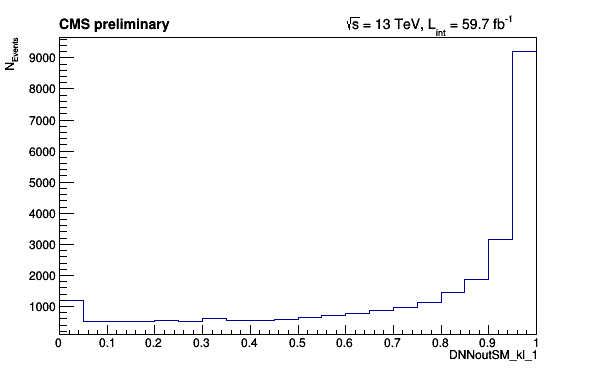

In [5]:
# Make global style changes
ROOT.gStyle.SetOptStat(0) # Disable the statistics box
ROOT.gStyle.SetTextFont(42)

# Create a canvas
c = ROOT.TCanvas('c', 'DNNoutSM_kl_1', 600, 400)

# Create a histogram and draw it
h = ROOT.TH1F('h', ';DNNoutSM_kl_1; N_{Events}', 20, 0, 1)
tree.Draw("DNNoutSM_kl_1>>h")

# Let's add some CMS style headline
label = ROOT.TLatex()
label.SetNDC(True)
label.SetTextSize(0.040)
label.DrawLatex(0.10, 0.92, '#bf{CMS preliminary}')
label.DrawLatex(0.58, 0.92, '#sqrt{s} = 13 TeV, L_{int} = 59.7 fb^{-1}')

# show interactively
c.Draw()

Now that we have seen this let's try and fill a histogram starting from the information iside a dataframe. 

Instead of using `uproot` this time we create a dataframe and fill it iteratively looping on the events contained in the tree.

In [6]:
Nevents = tree.GetEntries() # get the number of events inside the tree 

# create a dataframe that will contain the information we need
dau1df = pd.DataFrame(columns = ["dau1Pt", "dau1Eta", "dau1Phi", "dau1Flav"], index = range(Nevents))
dau2df = pd.DataFrame(columns = ["dau2Pt", "dau2Eta", "dau2Phi", "dau2Flav"], index = range(Nevents))

for i in range(Nevents):
    tree.GetEntry(i)
    dau1df["dau1Pt"][i] = tree.dau1_pt
    dau1df["dau1Eta"][i] = tree.dau1_eta
    dau1df["dau1Phi"][i] = tree.dau1_phi
    dau1df["dau1Flav"][i] = tree.dau1_flav
    dau2df["dau2Pt"][i] = tree.dau1_pt
    dau2df["dau2Eta"][i] = tree.dau1_eta
    dau2df["dau2Phi"][i] = tree.dau1_phi
    dau2df["dau2Flav"][i] = tree.dau1_flav

dau1df.head()

,dau1Pt,dau1Eta,dau1Phi,dau1Flav
0,57.8447,1.3984,-1.36566,3
1,195.437,-0.407139,2.61277,3
2,77.5814,-1.42875,2.10226,-3
3,63.6985,0.161933,2.54874,-3
4,47.5043,-1.06921,-1.16261,-3


As you can see doing this takes a pretty long time!! So you might consider doing the reading of the `ROOT` file only once, you save the info inside a `.csv` file and then from then on you just read the `.csv` file which is a way faster method of reading data. Now this has the disadvantage that you will not be able to use the `ROOT` libraries on it.

Now that we have the DataFrame ready we can fill the histogram looping o the data inside the DataFrame.

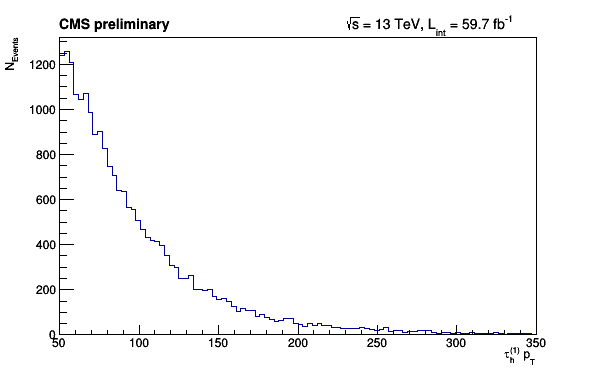

In [7]:
# Create a canvas
c1 = ROOT.TCanvas('c1', 'dau1_pt', 600, 400)

# Create a histogram and draw it
h1 = ROOT.TH1F('h1', ';#tau_{h}^{(1)} p_{T}; N_{Events}', 100, 50, 350)
for pt in dau1df["dau1Pt"]:
    if pt > 50: # I put this cut just for the fitting purpose
        h1.Fill(pt)
h1.Draw()
    
# Let's add some CMS style headline
label = ROOT.TLatex()
label.SetNDC(True)
label.SetTextSize(0.040)
label.DrawLatex(0.10, 0.92, '#bf{CMS preliminary}')
label.DrawLatex(0.58, 0.92, '#sqrt{s} = 13 TeV, L_{int} = 59.7 fb^{-1}')

# show interactively
c1.Draw()

Now that we have a plot we can try to fit it with user defined functions using `ROOT`. We do it like this:

 FCN=20416.3 FROM HESSE     STATUS=FAILED         11 CALLS          68 TOTAL
                     EDM=1.56149e-14    STRATEGY= 1  ERROR MATRIX UNCERTAINTY 100.0 per cent
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -2.97339e+03   4.24264e-01   1.83875e+01   0.00000e+00
   2  p1           1.09266e+00   1.41421e+00   1.09266e+00   0.00000e+00
   3  p2           1.83875e+01   4.28806e-01   1.83875e+01   2.91413e-07


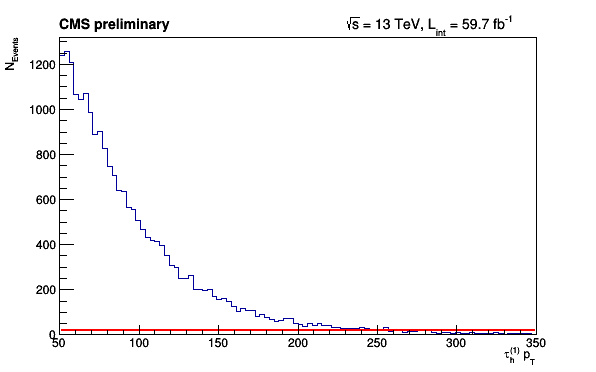

In [8]:
# Fit an inverse exponential function to the data
f = ROOT.TF1('f', '[0] * exp(-[1]*x) + [2]')
h1.Fit(f)

c1.Draw()

Why has the fit failed? Hint: what is the weak spot of every minimization (e.g. Newton-Rafson, bisection, etc.)? 

 FCN=131.163 FROM MIGRAD    STATUS=CONVERGED      79 CALLS          80 TOTAL
                     EDM=1.01971e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.23892e+03   7.65495e+01   1.61036e-01  -4.59370e-06
   2  p1           2.16982e-02   1.89553e-04   3.62219e-07   6.99649e-01
   3  p2           1.54596e+00   5.52721e-01   2.40706e-03   8.66591e-04


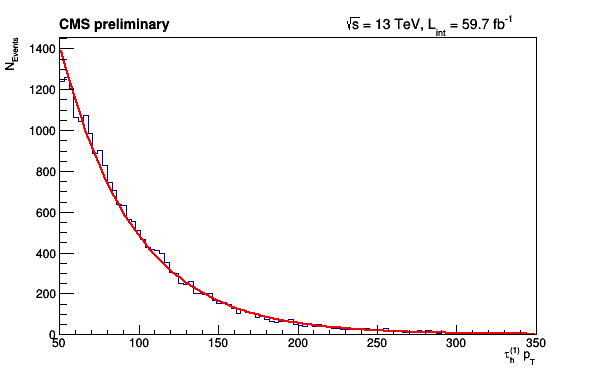

In [9]:
# Fit an inverse exponential function to the data
f = ROOT.TF1('f', '[0] * exp(-[1]*x) + [2]')
f.SetParameters(4000, 0.02, 0)
h1.Fit(f)

c1.Draw()

A very cool feature (honestly I hve never used it but I discovered it writing this tutorial and I want to share it with you). It is the `%jsroot on` magic, which enables ROOT’s JavaScript integration! This allows you to interact with the visualization such as you are used to it from the interactive graphics in the Python prompt. 

In [10]:
%jsroot on
c1.Draw()

In [11]:
%jsroot off

## 1.2 `RDataFrame` data handling

`RDataFrame` is `ROOT`’s high-level (and __very new__) interface for efficient data analysis. With `RDataFrame`, it is possible to read, select, modify and write `ROOT` data, as well as easily produce histograms, cut-flow reports and other results. In this and the following sections, you will learn how to perform data analysis with `RDataFrame`, running all your tasks efficiently on multiple threads!

`ROOT` tries to make parallelization as simple as possible for you. For this reason, we offer the feature `ROOT.EnableImplicitMT(N)`, which enables thread safety for the relevant classes and runs parallelized parts of `ROOT`, such as `RDataFrame`, implicitely on `N` threads:

In [12]:
# Enable multi-threading with the specified amount of threads (let's start with just one)
# Note that older ROOT versions require to write ROOT.ROOT.EnableImplicitMT()
ROOT.ROOT.EnableImplicitMT(1)

# Or enable multi-threading with an auto-detected amount of threads
#ROOT.ROOT.EnableImplicitMT()

A possible way to construct an `RDataFrame` is passing one (ore more) filepaths and the name of the dataset (i.e. the name of the `TTree` object in the file, which is called `HTauTauTree` for us).


In [15]:
df = ROOT.RDataFrame("HTauTauTree", "/data_CMS/cms/motta/HHLegacy_SKIMS/SKIMS2018/TREX/SKIM_GGHH_NLO_cHHH1_xs.root")

Next, you can apply selections and other transormations to the dataframe. The first basic transformation is applying cuts with the `Filter` method. Note that each transformation returns a new, transformed dataframe and does not change the dataframe object itself!

In [16]:
# For simplicity, select only events with exactly two muons and require opposite charge
df_ptCut = df.Filter("dau1_pt > 50 && dau2_pt > 50", "Events where both taus have pT > 50 GeV")

The next code block uses `PyROOT` to inject a `C++` implementation of the $\Delta R = \sqrt{(\Delta\phi)^2+(\Delta\eta)^2}$  computation. The name of the just-in-time compiled function can be used in the `Define` method to add a new column to the dataset, which will contain the angular separation.

In [ ]:
# Perform the computation of the angular separation in C++
ROOT.gInterpreter.Declare('''
float ComputeDeltaR(Double_t eta1, Double_t phi1, Double_t eta2, Double_t phi2) {
    return sqrt((eta1-eta2)*(eta1-eta2) + (phi1-phi2)*(phi1-phi2));
}
''')

# Add the result of the computation to the dataframe
df_dR = df_ptCut.Define("dR", "ComputeDeltaR(dau1_eta, dau1_phi, dau2_eta, dau2_phi)")

At any point, you can book the computation of results, e.g., histograms or a report. Both of them are added below. Please note that `RDataFrame` is lazy! This means that the computation does not run right away, when you book a histogram, but you can accumulate multiple results and compute all of them in one go. The computation of all booked results is triggered only when you actually access one of the results!

In [ ]:
h_dR = df_dR.Histo1D(("dR",";#DeltaR(#tau,#tau);N_{Events}", 25, 0, 10), "dR")
report = df_dR.Report()

As explained above, accessing a dataframe result triggers the computation (sometimes called “event loop”) of all results booked up to that point. Here, this happens when we draw the histogram. However, you just have to remember to book all results first and then start working with the results so that they can all be computed in one go! 

In [ ]:
c2 = ROOT.TCanvas("c2", "dR", 600, 400)
h_dR.Draw()

label = ROOT.TLatex()
label.SetNDC(True)
label.SetTextSize(0.040)
label.DrawLatex(0.100, 0.920, "#bf{CMS Preliminary}")
label.DrawLatex(0.550, 0.920, "#sqrt{s} = 13 TeV, L_{int} = 59.7 fb^{-1}")

# show interactively
c2.Draw()

We also print the cut-flow report to investigate the efficiency of the filters.

In [ ]:
# Print cut-flow report
report.Print()

### 1.3 Getting help with `ROOT`

The [`ROOT` website](https://root.cern) is home to the [beginner’s guide](https://root.cern/primer/) and the more in-depth [manual],(https://root.cern/manual/). These are a great resource to start with `ROOT` and learn about parts of the framework in high detail. Keep in mind the [`ROOT` website](https://root.cern), which provides links to all resources in a single place!

The [reference guide](https://root.cern/doc/master/index.html) provides a more technical documentation about `ROOT` powered by [Doxygen](https://www.doxygen.nl/index.html). You can search for classes or functions in `ROOT`, learn about types and methods and trace features down to the actual implementation.

Although the reference guide is more technical in first place, important classes have extensive additional documentation. Feel free to investigate [`TTree`](https://root.cern/doc/master/classTTree.html) or [`RDataFrame`](https://root.cern/doc/master/classROOT_1_1RDataFrame.html)!

Another part of the reference guide are the [tutorials](https://root.cern/doc/master/group__Tutorials.html), which explain features in working code examples. Feel free to look at tutorials for [`RooFit`](https://root.cern/doc/master/group__tutorial__roofit.html) and [`RDataFrame`](https://root.cern/doc/master/group__tutorial__dataframe.html), which cover many typical use cases for these parts of `ROOT`!

The [`ROOT` forum](https://root-forum.cern.ch/) is the to-go place if you cannot find the answer in the documentation. Don’t hesitate to open a discussion, there is always someone from the `ROOT` team actively taking care of new questions in the forum!

But not only questions are very welcome, you can also discuss possible improvements or make suggestions for new features!

Bugs are currently tracked on [Jira](https://sft.its.cern.ch/jira/projects/ROOT/summary), but we will soon switch to [GitHub issues](https://github.com/root-project/root). However, if you discover bugs, please report them! In case you are not sure whether you see a bug or a feature, posting in the `ROOT` forum is always a good idea and always appreciated!

### 1.4 `TLorentzVector` 

A very useful feature of `ROOT` is the possibility to define relativistic four-vectors. This can be done using the `TLorentzVector` class. The functions of this class allow the initialization and handling of the vector and its properties. Lets see how it works.

In [ ]:
Mtau = 1.777 #GeV 

# define a TLrentzVector
vect1 = ROOT.TLorentzVector()
# fill it we the information we have
vect1.SetPtEtaPhiM(30,1.5,np.pi/2,Mtau)

Now that we have set the vector we can compute the stuff we might need. For example we could need the mass x, y, z projections of the momentum of the particle, or its energy:

In [ ]:
print('P =', vect1.P(), '; Px =', vect1.Px(), '; Py =', vect1.Py(), '; Pz =', vect1.Pz())
print('E =', vect1.E())

Now suppose we want to reconstruct a particle decaying in two $\tau$ leptons. Then we would have a second vector for the second $\tau$ lepton:

In [ ]:
vect2 = ROOT.TLorentzVector()
vect2.SetPtEtaPhiE(50,-1.5,-np.pi/2,70.595)

Then the two vectors of the reconstructed tau leptons should be added together to form the four-vector of the particle we are trying to reconstruct:

In [ ]:
vect = vect1 + vect2

Let's see what are we reconstructing:

In [ ]:
print('E =', vect.E(), '; M =', vect.M())

Given the angular configuration of the two $\tau$ leptons that we have defined, and given the E and M of the particle they come from, what can we say about it? How was it produced?

### 1.5 For next time

I would like you to start working with the NTuples I provide you in the folder `SKIMS`. Take these two: 
* `SKIM_GGHH_NLO_cHHH1_xs.root` which contains the signal of double Higgs production trhough gluon fusion 
* `SKIM_TT_fullyHad.root` which contains the biggest background to our analysis

I would like you to this:
* construct the four-vector fo the Higgs candidate decaying into two $\tau$ leptons
* plot the distribution of the mass of the Higgs candidates you reconstruct and understand:
    * why they have such a shape
    * why are they the same if they are the same and why are they different if they are different
* fit this distributions of the mass to see if they are consistent with a Higgs boson or if they are not (NB choose the appropriate function)
* **_ONLY_ IF YOU HAVE HAVE DONE THE ABOVE AND YOU HAVE UNDESTROOD IT**: do the same for the Higgs boson decaying to two b quarks


You have all the knowledge you need to do this, the only thing you need more is to know how the variables are called in the tree:
* `dau1_pt` transverse momentum of the first $\tau$ lepton
* `dau1_eta` eta of the first $\tau$ lepton
* `dau1_phi` phi of the first $\tau$ lepton
* `dau1_e` energy of the first $\tau$ lepton

* `dau2_pt` transverse momentum of the second $\tau$ lepton
* `dau2_eta` eta of the second $\tau$ lepton
* `dau2_phi` phi of the second $\tau$ lepton
* `dau2_e` energy of the second $\tau$ lepton

* `bjet1_pt` transverse momentum of the first b quark jet
* `bjet1_eta` eta of the first b quark jet
* `bjet1_phi` phi of the first b quark jet
* `bjet1_e` energy of the first b quark jet

* `bjet2_pt` transverse momentum of the second b quark jet
* `bjet2_eta` eta of the second b quark jet
* `bjet2_phi` phi of the second b quark jet
* `bjet2_e` energy of the second b quark jet

**WORK TOGETHER, I WOULD LIKE BOTH OF YOU TO ARRIVE WITH THE SMAE LEVEL OF KNOWLEDGE OF WHAT YOU HAVE DONE!**

**LIKE ALWAYS, I AM AVAILABLE FOR ANY PROBLEM OR DOUBT. CONTACT ME ON SKYOE. BUT I ASK YOU TRY AND FIGURE OUT DOUBTS TOGETEHR BEFORE ASKING ME**